# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Cdf

import thinkbayes2

import thinkplot

import numpy as np
import pandas as pd

# The D&D problem

Suppose there are 10 people in my Dungeons and Dragons club; on any game day, each of them has a 70% chance of showing up.

Each player has one character and each character has 6 attributes, each of which is generated by rolling and adding up 3 6-sided dice.

At the beginning of the game, I ask whose character has the lowest attribute. The wizard says, "My constitution is 5; does anyone have a lower attribute?", and no one does.

The warrior says "My strength is 16; does anyone have a higher attribute?", and no one does.

How many characters are in the party?

Prior probabilites


,hypo,prior,likelihood,unnorm,posterior
0,0,0.000006,NaN,NaN,NaN
1,1,0.000138,NaN,NaN,NaN
2,2,0.001447,NaN,NaN,NaN
3,3,0.009002,NaN,NaN,NaN
4,4,0.036757,NaN,NaN,NaN
5,5,0.102919,NaN,NaN,NaN
6,6,0.200121,NaN,NaN,NaN
7,7,0.266828,NaN,NaN,NaN
8,8,0.233474,NaN,NaN,NaN
9,9,0.121061,NaN,NaN,NaN


Posterior probabilities


,hypo,prior,likelihood,unnorm,posterior
0,0,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.141452,0.000000,0.000000
2,2,0.001076,0.232882,0.000251,0.000798
3,3,0.008288,0.288263,0.002389,0.007610
4,4,0.037327,0.317944,0.011868,0.037801
5,5,0.108334,0.329558,0.035702,0.113716
6,6,0.210110,0.328715,0.069066,0.219984
7,7,0.272306,0.319515,0.087006,0.277124
8,8,0.227396,0.304935,0.069341,0.220859
9,9,0.111020,0.287120,0.031876,0.101530


There are between 5 and 9 players with 90% condfidence


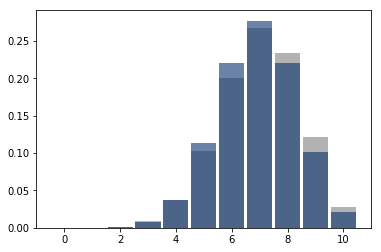

In [2]:
prior = thinkbayes2.MakeBinomialPmf(10, 0.7)

class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)
    
dnd = BayesTable(range(11),prior.Probs(range(11)))
print("Prior probabilites")
display(dnd)

#update for there being at least two people
dnd.likelihood=[0,0]+[1]*9
dnd.update()
dnd=dnd.reset()

d6=Pmf(range(1,7))
stat=d6+d6+d6

nd6=Pmf(range(-6,0))
nstat=nd6+nd6+nd6

#update for the max being 16
dnd.likelihood=[stat.Max(6*x).MakePmf().Prob(16) for x in range(11)]
dnd.update()
dnd=dnd.reset()

#update for the min being 5
dnd.likelihood=[nstat.Max(6*x).MakePmf().Prob(-5) for x in range(11)]
dnd.update()
print("Posterior probabilities")
display(dnd)
thinkplot.Hist(prior, color='gray')
post=Pmf(dnd.posterior.to_dict())
thinkplot.hist(post)

print("There are between %d and %d players with 90%% condfidence" % post.CredibleInterval())

# The Cat Allergy Problem

Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

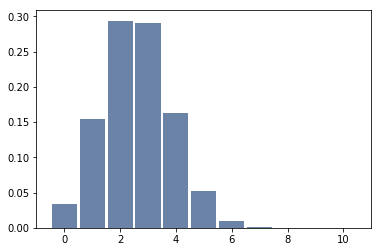

In [3]:
allergy=thinkbayes2.MakeBinomialPmf(4,.5)
catpeople=thinkbayes2.MakeBinomialPmf(6,.1)

total=allergy+catpeople

thinkplot.hist(total)

# The Gluten Problem

In [4]:
class Gluten(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: number of correct subjects
        hypo: number of subjects with NCGS
        """
        ncgs=thinkbayes2.MakeBinomialPmf(hypo,.95)
        hypochondriacs=thinkbayes2.MakeBinomialPmf(36-hypo,.4)
        total = ncgs+hypochondriacs
        return total.Prob(data)

Given the general misdiagnosis rate of NCGS, I'd say that between 9 and 15 of the subjects had NCGS (90% condfidence)


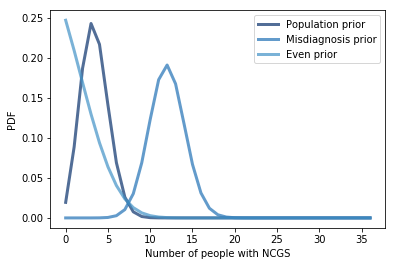

In [5]:
#Wikipedia lists the prevalence of NCGS at 0.5-13%. I'll go with 13% since this trial was specifically people
#who thought they had NCGS.
priorPop=Gluten(thinkbayes2.MakeBinomialPmf(36,.13),label='Population prior')

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4737868/ says that 
#diagnosis was confirmed in only 64 of the 107 subjects with a previous diagnosis
priorMis=Gluten(thinkbayes2.MakeBinomialPmf(36,64/107),label='Misdiagnosis prior')

#and for the sake of completion here's an even prior
priorEven=Gluten(range(37),'Even prior')

postPop=priorPop.Copy()
postMis=priorMis.Copy()
postEven=priorEven.Copy()

postPop.Update(12)
postMis.Update(12)
postEven.Update(12)

thinkplot.Pdf(postPop)
thinkplot.Pdf(postMis)
thinkplot.Pdf(postEven)


#The misdiagnons rate seems like the most resonable prior to me
print("Given the general misdiagnosis rate of NCGS, I'd say that between %d and %d of the subjects had NCGS (90%% condfidence)" % postMis.CredibleInterval())
thinkplot.Config(xlabel='Number of people with NCGS', ylabel='PDF')

# The Height Problem

1) For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male?  

2) Run this analysis again for a range of observed heights from 150 cm to 200 cm, and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?

F 0.5431967423330698
M 0.4568032576669302
This is a logistic of some kind, I do beleive.


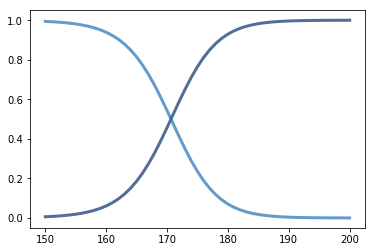

In [13]:
class Sex(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: height
        hypo: 'M' or 'F'
        """
        if hypo=='M':
            return thinkbayes2.EvalNormalCdf(data+.5,178,7.7)-thinkbayes2.EvalNormalCdf(data-.5,178,7.7)
        else:
            return thinkbayes2.EvalNormalCdf(data+.5,163,7.3)-thinkbayes2.EvalNormalCdf(data-.5,163,7.3)


#data from https://www.statista.com/statistics/737923/us-population-by-gender/
nm=159.68
nf=166.2
tot=nm+nf
        
prior = {'M':nm/tot,'F':nf/tot}
sex = Sex(prior)
sex.Update(170)
sex.Print()

def pm(x):
    sex = Sex(prior)
    sex.Update(x)
    return sex.Prob('M')

def pf(x):
    sex = Sex(prior)
    sex.Update(x)
    return sex.Prob('F')

xs=range(150,201)
testM=[pm(x) for x in xs];
testF=[pf(x) for x in xs];

thinkplot.plot(xs,testM,label='')
thinkplot.plot(xs,testF)

print("This is a logistic of some kind, I do beleive.")

thinkplot.Config(xlabel='Height(cm)', ylabel='PDF')